In [1]:
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np

2024-03-07 14:12:18.402278: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 14:12:18.542526: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-07 14:12:18.542685: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-07 14:12:18.560689: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-03-07 14:12:18.623266: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-07 14:12:18.625183: I tensorflow/core/platform/cpu_feature_guard.cc:1

In [2]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(60)

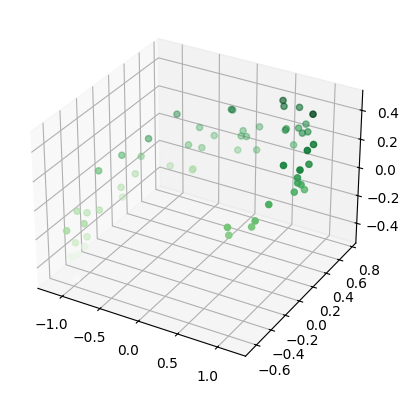

In [3]:
fig = plt.figure()
ax = plt.axes(projection='3d')
ax.scatter3D(X_train[:,0], X_train[:, 1], X_train[:, 2], c=X_train[:, 2], cmap='Greens')

In [4]:
encoder = keras.models.Sequential(keras.layers.Dense(2, input_shape=[3]))
decoder = keras.models.Sequential(keras.layers.Dense(3, input_shape=[2]))
autoencoder = keras.models.Sequential([encoder, decoder])
autoencoder.compile(loss='mse', optimizer=keras.optimizers.SGD(lr=1.5))

autoencoder.fit(X_train, X_train, epochs=30)

2024-03-07 14:12:21.496980: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:06:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-03-07 14:12:21.711550: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


Epoch 1/30
2/2 [==============================] - 0s 6ms/step - loss: 1.4353
Epoch 2/30
2/2 [==============================] - 0s 4ms/step - loss: 1.3592
Epoch 3/30
2/2 [==============================] - 0s 5ms/step - loss: 1.2906
Epoch 4/30
2/2 [==============================] - 0s 4ms/step - loss: 1.2281
Epoch 5/30
2/2 [==============================] - 0s 4ms/step - loss: 1.1725
Epoch 6/30
2/2 [==============================] - 0s 5ms/step - loss: 1.1211
Epoch 7/30
2/2 [==============================] - 0s 5ms/step - loss: 1.0739
Epoch 8/30
2/2 [==============================] - 0s 4ms/step - loss: 1.0303
Epoch 9/30
2/2 [==============================] - 0s 4ms/step - loss: 0.9905
Epoch 10/30
2/2 [==============================] - 0s 4ms/step - loss: 0.9529
Epoch 11/30
2/2 [==============================] - 0s 4ms/step - loss: 0.9192
Epoch 12/30
2/2 [==============================] - 0s 5ms/step - loss: 0.8877
Epoch 13/30
2/2 [==============================] - 0s 7ms/step - loss: 0.

In [5]:
codings = encoder.predict(X_train)

2/2 [==============================] - 0s 3ms/step


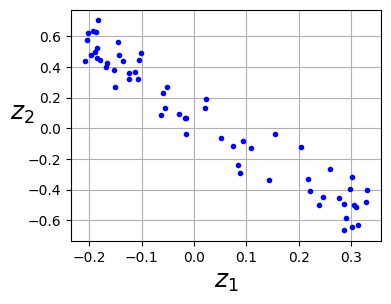

In [6]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

In [7]:
from sklearn.model_selection import train_test_split

(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train, X_val, y_train, y_val = train_test_split(X_train_full, y_train_full, test_size=0.2)

X_train = X_train.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_val = X_val.astype(np.float32) / 255

In [8]:
def rounded_accuracy(y_true, y_pred):
    return keras.metrics.binary_accuracy(tf.round(y_true), tf.round(y_pred))

In [9]:
stacked_encoder = keras.models.Sequential([keras.layers.Flatten(input_shape=[28,28]),
                                          keras.layers.Dense(100, activation='selu'),
                                          keras.layers.Dense(30, activation='selu')])

stacked_decoder = keras.models.Sequential([keras.layers.Dense(100, activation='selu', input_shape=[30]),
                                          keras.layers.Dense(784, activation='sigmoid'),
                                          keras.layers.Reshape([28, 28])])

stacked_ae = keras.models.Sequential([stacked_encoder, stacked_decoder])
stacked_ae.compile(loss='binary_crossentropy', optimizer=keras.optimizers.SGD(learning_rate=1.5), metrics=[rounded_accuracy])

In [10]:
history = stacked_ae.fit(X_train, X_train, epochs=30, validation_data=(X_val, X_val))

Epoch 1/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3418 - rounded_accuracy: 0.8840 - val_loss: 0.3124 - val_rounded_accuracy: 0.9096
Epoch 2/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3087 - rounded_accuracy: 0.9124 - val_loss: 0.3036 - val_rounded_accuracy: 0.9158
Epoch 3/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.3017 - rounded_accuracy: 0.9186 - val_loss: 0.2989 - val_rounded_accuracy: 0.9230
Epoch 4/30
1500/1500 [==============================] - 5s 3ms/step - loss: 0.2978 - rounded_accuracy: 0.9222 - val_loss: 0.3032 - val_rounded_accuracy: 0.9101
Epoch 5/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2952 - rounded_accuracy: 0.9244 - val_loss: 0.2932 - val_rounded_accuracy: 0.9261
Epoch 6/30
1500/1500 [==============================] - 4s 3ms/step - loss: 0.2933 - rounded_accuracy: 0.9262 - val_loss: 0.2929 - val_rounded_accuracy: 0.9255
Epoch 7/30
1500/1500 [==================

In [11]:
def plot_image(image):
    plt.imshow(image, cmap='binary')
    plt.axis('off')

In [12]:
def show_reconstructions(model, n_images=5):
    true_images = X_val[:n_images]
    recon_images = model.predict(true_images)

    figure = plt.figure(figsize=(8.6, 6))
    for i in range(n_images):
        figure.add_subplot(2, n_images, i + 1)
        plot_image(true_images[i])
        figure.add_subplot(2, n_images, i + 1 + n_images)
        plot_image(recon_images[i])

In [13]:
# show_reconstructions(stacked_ae)

In [14]:
from sklearn.manifold import TSNE

X_val_compressed = stacked_encoder.predict(X_val)
tsne = TSNE()
X_val_2D = tsne.fit_transform(X_val_compressed)

375/375 [==============================] - 0s 1ms/step


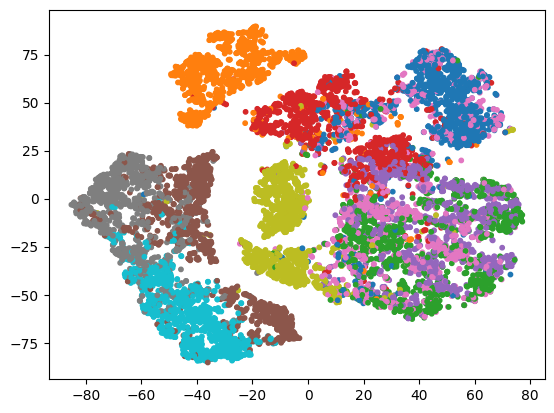

In [15]:
plt.scatter(X_val_2D[:,0], X_val_2D[:, 1], c=y_val, s=10, cmap='tab10')